In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [3]:
data_FSR7 = pd.read_csv("Ana_FSR7_conv_frame.csv", header = None)
data_FSR7 = data_FSR7.to_numpy()

In [4]:
time_step = np.arange(0,len(data_FSR7),1)
series = data_FSR7
time = time_step

In [5]:
series.shape

(910, 1)

In [6]:
split_time = int(.80*len(series))
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 32
batch_size = 60
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=50, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=90, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(N1, return_sequences=True),
  tf.keras.layers.LSTM(N2, return_sequences=True),
  tf.keras.layers.Dense(N3, activation="relu"),
  tf.keras.layers.Dense(N4),
    
  tf.keras.layers.Lambda(lambda x: x * 250)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])



/Users/wearmelab/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [10]:
history = model.fit(train_set,epochs = 20)


Epoch 1/20
7/7 [==============================] - 8s 636ms/step - loss: 7.1187 - mae: 7.6098
Epoch 2/20
7/7 [==============================] - 5s 667ms/step - loss: 3.0517 - mae: 3.5241
Epoch 3/20
7/7 [==============================] - 4s 527ms/step - loss: 1.8253 - mae: 2.2935
Epoch 4/20
7/7 [==============================] - 4s 523ms/step - loss: 0.9304 - mae: 1.3672
Epoch 5/20
7/7 [==============================] - 4s 518ms/step - loss: 0.4593 - mae: 0.8436
Epoch 6/20
7/7 [==============================] - 4s 514ms/step - loss: 0.2730 - mae: 0.6352
Epoch 7/20
7/7 [==============================] - 5s 678ms/step - loss: 0.1433 - mae: 0.4396
Epoch 8/20
7/7 [==============================] - 4s 559ms/step - loss: 0.0786 - mae: 0.3258
Epoch 9/20
7/7 [==============================] - 5s 679ms/step - loss: 0.0400 - mae: 0.2299
Epoch 10/20
7/7 [==============================] - 6s 781ms/step - loss: 0.0252 - mae: 0.1788
Epoch 11/20
7/7 [==============================] - 9s 1s/step - loss:

In [22]:
rnn_forecast = model_forecast(model, series, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

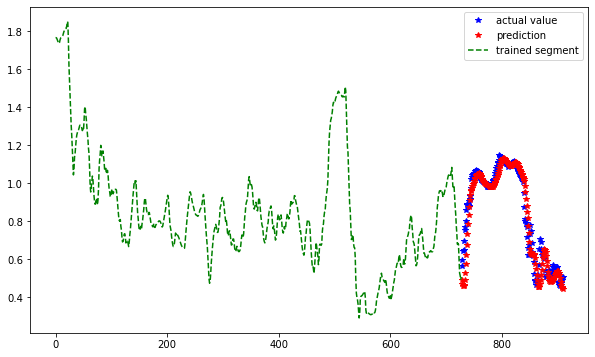

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid, 'b*', label = 'actual value')
plt.plot(time_valid, rnn_forecast, 'r*', label = 'prediction')
plt.plot(time_train, x_train, 'g--', label = 'trained segment')
plt.legend()